# Experiment 01: Airline dataset

In this experiment we use [the airline dataset](http://kt.ijs.si/elena_ikonomovska/data.html) to predict arrival delay. The dataset consists of a large amount of records, containing flight arrival and departure details for all the commercial flights within the USA, from October 1987 to April 2008. Its size is around 116 million records and 5.76 GB of memory.



In [1]:
import os,sys
import numpy as np
import pandas as pd
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, precision_score,
                             recall_score)
from libs.loaders import load_airline
from libs.conversion import convert_cols_categorical_to_numeric, convert_related_cols_categorical_to_numeric
from libs.timer import Timer
from libs.utils import get_number_processors
from libs.notebook_memory_management import start_watching_memory
import pkg_resources
import json
import matplotlib.pylab as plt

print("System version: {}".format(sys.version))
print("XGBoost version: {}".format(pkg_resources.get_distribution('xgboost').version))
print("LightGBM version: {}".format(pkg_resources.get_distribution('lightgbm').version))

%matplotlib inline

System version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
XGBoost version: 0.6
LightGBM version: 0.2


In [2]:
start_watching_memory()

In [2] used 9.7539 MiB RAM in 0.29s, peaked 0.00 MiB above current, total RAM usage 124.00 MiB


/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.504199. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


# 1) XGBoost vs LightGBM benchmark
In the next section we compare both libraries speed, accuracy and other metrics for the dataset of airline arrival delay. 

### Data loading and management

In [3]:
%%time
df_plane = load_airline()
print(df_plane.shape)

MOUNT_POINT not found in environment. Defaulting to /fileshare


/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.529082. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(115069017, 14)
CPU times: user 1min 36s, sys: 14.9 s, total: 1min 51s
Wall time: 5min 16s
In [3] used 21994.4492 MiB RAM in 317.01s, peaked 12290.76 MiB above current, total RAM usage 22118.45 MiB


In [4]:
df_plane.head()

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.551778. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,SFO,ORD,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,LAX,SFO,337,0,5
2,1987,10,1,4,5,35,HP,351,167,ICT,LAS,987,0,17
3,1987,10,1,4,5,40,DL,251,35,MCO,PBI,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,LAS,ORD,1515,0,17


In [4] used 0.2188 MiB RAM in 0.40s, peaked 0.00 MiB above current, total RAM usage 22118.66 MiB


The first step is to convert the categorical features to numeric features.

In [5]:
%%time
df_plane_numeric = convert_related_cols_categorical_to_numeric(df_plane, col_list=['Origin','Dest'])
del df_plane

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.603459. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


CPU times: user 1min 41s, sys: 7.75 s, total: 1min 49s
Wall time: 1min 48s
In [5] used 5269.6680 MiB RAM in 108.89s, peaked 0.00 MiB above current, total RAM usage 27388.33 MiB


In [6]:
df_plane_numeric.head()

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.620527. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,HP,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,DL,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,4,33,1515,0,17


In [6] used 0.0156 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 27388.35 MiB


In [7]:
%%time
df_plane_numeric = convert_cols_categorical_to_numeric(df_plane_numeric, col_list='UniqueCarrier')


/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.688889. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


CPU times: user 1min 1s, sys: 8.4 s, total: 1min 9s
Wall time: 1min 9s
In [7] used 12288.9062 MiB RAM in 69.50s, peaked 0.00 MiB above current, total RAM usage 39677.25 MiB


In [8]:
df_plane_numeric.head()

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.693215. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17


In [8] used 0.0039 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 39677.26 MiB


To simplify the pipeline, we are going to set a classification problem where the goal is to classify wheather a flight has arrived delayed or not. For that we need to binarize the variable `ArrDelay`.

If you want to extend this experiment, you can set a regression problem and try to identify the number of minutes of delay a fight has. Both XGBoost and LightGBM have regression classes.

In [9]:
%%time
df_plane_numeric['ArrDelayBinary'] = 1*(df_plane_numeric['ArrDelay'] > 0)

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.700942. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


CPU times: user 500 ms, sys: 480 ms, total: 980 ms
Wall time: 662 ms
In [9] used 877.9336 MiB RAM in 0.77s, peaked 770.41 MiB above current, total RAM usage 40555.19 MiB


In [10]:
df_plane_numeric.head()

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.709710. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay,ArrDelayBinary
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27,1
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5,1
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17,1
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2,0
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17,1


In [10] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 40555.19 MiB


Once the features are prepared, let's split the dataset into train, validation and test set.

In [11]:
def split_train_val_test_df(df, val_size=0.2, test_size=0.2):
    train, validate, test = np.split(df.sample(frac=1), 
                                     [int((1-val_size-test_size)*len(df)), int((1-test_size)*len(df))])
    return train, validate, test

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.717309. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [11] used 0.0195 MiB RAM in 0.17s, peaked 0.00 MiB above current, total RAM usage 40555.21 MiB


In [12]:
%%time
train, validate, test = split_train_val_test_df(df_plane_numeric)
print(train.shape)
print(validate.shape)
print(test.shape)

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.724178. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(69041410, 15)
(23013803, 15)
(23013804, 15)
CPU times: user 52.5 s, sys: 36.9 s, total: 1min 29s
Wall time: 1min 27s
In [12] used 14039.7695 MiB RAM in 87.80s, peaked 26312.12 MiB above current, total RAM usage 54594.98 MiB


In [13]:
def generate_feables(df):
    X = df[df.columns.difference(['ArrDelay', 'ArrDelayBinary'])]
    y = df['ArrDelayBinary']
    return X,y

In [13] used 0.1367 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 54595.12 MiB


/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.731640. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [14]:
%%time
X_train, y_train = generate_feables(train)
X_val, y_val = generate_feables(validate)
X_test, y_test = generate_feables(test)


/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.738837. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


CPU times: user 2.03 s, sys: 2.75 s, total: 4.78 s
Wall time: 4.7 s
In [14] used 11412.8750 MiB RAM in 4.94s, peaked 0.00 MiB above current, total RAM usage 66007.99 MiB


### Training 
Now we are going to create two pipelines, one of XGBoost and one for LightGBM. The technology behind both libraries is different, so it is difficult to compare them in the exact same model setting. XGBoost grows the trees depth-wise and controls model complexity with `max_depth`. Instead, LightGBM uses a leaf-wise algorithm and controls the model complexity by `num_leaves`. As a tradeoff, we use XGBoost with `max_depth=8`, which will have max number leaves of 255, and compare it with LightGBM with `num_leaves=255`. 

In [15]:
results_dict = dict()

In [15] used -0.0156 MiB RAM in 0.10s, peaked 0.02 MiB above current, total RAM usage 66007.98 MiB


/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.747804. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [16]:
number_processors = get_number_processors()
print(number_processors)

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.757547. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


20
In [16] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 66007.98 MiB


Let's start with the XGBoost classifier.

In [17]:
xgb_clf_pipeline = XGBRegressor(max_depth=8,
                                n_estimators=50,
                                min_child_weight=30,
                                learning_rate=0.1,
                                colsample_bytree=0.80,
                                scale_pos_weight=2,
                                gamma=0.1,
                                reg_lambda=1,
                                subsample=1,
                                n_jobs=number_processors,
                                random_state=77)

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.763914. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [17] used 0.0000 MiB RAM in 0.21s, peaked 0.00 MiB above current, total RAM usage 66007.98 MiB


In [18]:
with Timer() as t:
    xgb_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, eval_metric='logloss')

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-06-07 19:38:38.772070. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [18] used 17596.7969 MiB RAM in 1454.49s, peaked 1072.49 MiB above current, total RAM usage 83604.77 MiB


In [19]:
results_dict['xgb']={
    'train_time': t.interval
}

In [19] used 0.0664 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 83604.84 MiB


Training XGBoost model with leave-wise growth

In [20]:
xgb_hist_clf_pipeline = XGBRegressor(max_depth=0,
                                    n_estimators=50,
                                    min_child_weight=30,
                                    learning_rate=0.1,
                                    colsample_bytree=0.80,
                                    scale_pos_weight=2,
                                    gamma=0.1,
                                    reg_lambda=1,
                                    subsample=1,
                                    max_leaves=255,
                                    grow_policy='lossguide',
                                    tree_method='hist',
                                    n_jobs=number_processors,
                                    random_state=77)

In [20] used 0.0234 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 83604.86 MiB


In [21]:
with Timer() as t:
    xgb_hist_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, eval_metric='logloss')

In [21] used 20115.9141 MiB RAM in 537.86s, peaked 0.00 MiB above current, total RAM usage 103720.78 MiB


In [22]:
results_dict['xgb_hist']={
    'train_time': t.interval
}

In [22] used 0.0469 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 103720.82 MiB


Training LightGBM model

In [23]:
lgbm_clf_pipeline = LGBMRegressor(num_leaves=255,
                                  n_estimators=50,
                                  min_child_weight=30,
                                  learning_rate=0.1,
                                  colsample_bytree=0.80,
                                  scale_pos_weight=2,
                                  min_split_gain=0.1,
                                  reg_lambda=1,
                                  subsample=1,
                                  nthread=number_processors,
                                  seed=77)

In [23] used 0.0195 MiB RAM in 0.21s, peaked 0.00 MiB above current, total RAM usage 103720.84 MiB


In [24]:
def loglikelood(y_true, y_pred):
    eval_result = log_loss(y_true, y_pred)
    eval_name = 'log_loss'
    is_bigger_better = False
    return eval_name, eval_result, is_bigger_better

In [24] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 103720.85 MiB


In [25]:
with Timer() as t:
    lgbm_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, eval_metric=loglikelood)

In [25] used 3246.2734 MiB RAM in 756.52s, peaked 18369.75 MiB above current, total RAM usage 106967.12 MiB


In [26]:
results_dict['lgbm']={
    'train_time': t.interval
}

In [26] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 106967.13 MiB


As it can be seen in the results, given the specific versions and parameters of both XGBoost and LightGBM and in this specific dataset, LightGBM is faster. 

In general terms, leaf-wise algorithms are more efficient, they converge much faster than depth-wise. However, it may cause over-fitting when the data is small or there are too many leaves.

### Evaluation
Now let's evaluate the model in the test set.

In [27]:
with Timer() as t:
    y_prob_xgb = np.clip(xgb_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [27] used 199.4844 MiB RAM in 13.52s, peaked 7309.14 MiB above current, total RAM usage 107166.62 MiB


In [28]:
results_dict['xgb']['test_time'] = t.interval

In [28] used -0.0781 MiB RAM in 0.10s, peaked 0.08 MiB above current, total RAM usage 107166.54 MiB


In [29]:
with Timer() as t:
    y_prob_xgb_hist = np.clip(xgb_hist_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [29] used 87.7930 MiB RAM in 14.07s, peaked 7556.39 MiB above current, total RAM usage 107254.33 MiB


In [30]:
results_dict['xgb_hist']['test_time'] = t.interval

In [30] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 107254.33 MiB


In [31]:
with Timer() as t:
    y_prob_lgbm = np.clip(lgbm_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [31] used 2458.0508 MiB RAM in 15.94s, peaked 4565.12 MiB above current, total RAM usage 109712.38 MiB


In [32]:
results_dict['lgbm']['test_time'] = t.interval


In [32] used -0.0195 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 109712.36 MiB


### Metrics
We are going to obtain some metrics to evaluate the performance of each of the models.

In [33]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary(y_true, y_pred):
    m_acc = accuracy_score(y_true, y_pred)
    m_f1 = f1_score(y_true, y_pred)
    m_precision = precision_score(y_true, y_pred)
    m_recall = recall_score(y_true, y_pred)
    report = {'Accuracy':m_acc, 'Precision':m_precision, 'Recall':m_recall, 'F1':m_f1}
    return report

In [33] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 109712.36 MiB


In [34]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary_prob(y_true, y_prob):
    m_auc = roc_auc_score(y_true, y_prob)
    report = {'AUC':m_auc}
    return report

In [34] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 109712.36 MiB


In [35]:
def binarize_prediction(y, threshold=0.5):
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred

In [35] used 0.0000 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 109712.36 MiB


In [36]:
y_pred_xgb = binarize_prediction(y_prob_xgb)
y_pred_xgb_hist = binarize_prediction(y_prob_xgb_hist)
y_pred_lgbm = binarize_prediction(y_prob_lgbm)


In [36] used 526.6523 MiB RAM in 0.59s, peaked 0.00 MiB above current, total RAM usage 110239.02 MiB


In [37]:
report_xgb = classification_metrics_binary(y_test, y_pred_xgb)
report2_xgb = classification_metrics_binary_prob(y_test, y_prob_xgb)
report_xgb.update(report2_xgb)
print(report_xgb)

{'Accuracy': 0.63131305889282796, 'Precision': 0.57093822694344398, 'Recall': 0.89887294790305039, 'F1': 0.6983222551383752, 'AUC': 0.78574591886297918}
In [37] used -1764.3711 MiB RAM in 31.84s, peaked 1764.37 MiB above current, total RAM usage 108474.64 MiB


In [38]:
results_dict['xgb']['performance'] = report_xgb

In [38] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 108474.65 MiB


In [39]:
report_xgb_hist = classification_metrics_binary(y_test, y_pred_xgb_hist)
report2_xgb_hist = classification_metrics_binary_prob(y_test, y_prob_xgb_hist)
report_xgb.update(report2_xgb_hist)
print(report_xgb_hist)

{'Accuracy': 0.67368510655604785, 'Precision': 0.60939772125982838, 'Recall': 0.87073064934943689, 'F1': 0.71699358526074042}
In [39] used 13.9062 MiB RAM in 26.95s, peaked 730.49 MiB above current, total RAM usage 108488.56 MiB


In [40]:
results_dict['xgb_hist']['performance'] = report_xgb_hist

In [40] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 108488.57 MiB


In [41]:
report_lgbm = classification_metrics_binary(y_test, y_pred_lgbm)
report2_lgbm = classification_metrics_binary_prob(y_test, y_prob_lgbm)
report_lgbm.update(report2_lgbm)
print(report_lgbm)

{'Accuracy': 0.7356018587800609, 'Precision': 0.769833914912471, 'Recall': 0.63200874453226463, 'F1': 0.69414604097567745, 'AUC': 0.80881583890120923}
In [41] used 0.0117 MiB RAM in 28.01s, peaked 1199.01 MiB above current, total RAM usage 108488.58 MiB


In [42]:
results_dict['lgbm']['performance'] = report_lgbm

In [42] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 108488.59 MiB


In [43]:
# Results
print(json.dumps(results_dict, indent=4, sort_keys=True))

{
    "lgbm": {
        "performance": {
            "AUC": 0.8088158389012092,
            "Accuracy": 0.7356018587800609,
            "F1": 0.6941460409756774,
            "Precision": 0.769833914912471,
            "Recall": 0.6320087445322646
        },
        "test_time": 15.899643832002766,
        "train_time": 759.7789899049967
    },
    "xgb": {
        "performance": {
            "AUC": 0.8078158817136188,
            "Accuracy": 0.631313058892828,
            "F1": 0.6983222551383752,
            "Precision": 0.570938226943444,
            "Recall": 0.8988729479030504
        },
        "test_time": 13.46883549899212,
        "train_time": 1460.1219548319932
    },
    "xgb_hist": {
        "performance": {
            "Accuracy": 0.6736851065560479,
            "F1": 0.7169935852607404,
            "Precision": 0.6093977212598284,
            "Recall": 0.8707306493494369
        },
        "test_time": 14.043752847996075,
        "train_time": 540.0504210669897
    }
}
I

The experiment shows a fairly similar performance in both libraries, being LightGBM slightly better.

In [44]:
del xgb_clf_pipeline, xgb_hist_clf_pipeline, lgbm_clf_pipeline, X_train, X_test, X_val

In [44] used -51019.8906 MiB RAM in 1.39s, peaked 51019.83 MiB above current, total RAM usage 57468.69 MiB


# 2) Concept drift
In this section we are trying to find concept drift in the dataset to check if retraining is valuable.

### Data management
We are going to pack the data yearly to try to find concept drift

In [45]:
def get_data_list_yearly(df):
    data_yearly = [df[df['Year'] == year] for year in range(1987, 2008)]  
    return data_yearly

In [45] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 57468.69 MiB


In [46]:
%%time
data_yearly_list = get_data_list_yearly(df_plane_numeric)
del(df_plane_numeric)
for subset in data_yearly_list:
    print(subset.shape)

(1287333, 15)
(5126498, 15)
(290827, 15)
(5110527, 15)
(4995005, 15)
(5020651, 15)
(4993587, 15)
(5078411, 15)
(5219140, 15)
(5209326, 15)
(5301999, 15)
(5227051, 15)
(5360018, 15)
(5481303, 15)
(5723673, 15)
(5197860, 15)
(6375689, 15)
(6987729, 15)
(6992838, 15)
(7003802, 15)
(7275288, 15)
CPU times: user 8.61 s, sys: 3.78 s, total: 12.4 s
Wall time: 12.3 s
In [46] used 12753.6133 MiB RAM in 12.37s, peaked 0.00 MiB above current, total RAM usage 70222.30 MiB


In [47]:
total_subsets = len(data_yearly_list)
print("Number of years: {}".format(total_subsets))
num_ini = 5

Number of years: 21
In [47] used 0.0195 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 70222.32 MiB


In [48]:
def generate_subset(data_yearly_list, num):
    subset = data_yearly_list[0]
    for i in range(1,num):
        subset = pd.concat([subset, data_yearly_list[i]])
    return subset

In [48] used 0.0000 MiB RAM in 0.21s, peaked 0.00 MiB above current, total RAM usage 70222.32 MiB


### Traininig
Let's see what happens when we train on a subset of data and then evaluate in the data of the following years.

In [49]:
%%time
subset_base = generate_subset(data_yearly_list, num_ini)
print(subset_base.shape)

(16810190, 15)
CPU times: user 844 ms, sys: 1.4 s, total: 2.25 s
Wall time: 2.23 s
In [49] used 2052.0312 MiB RAM in 2.38s, peaked 1367.71 MiB above current, total RAM usage 72274.35 MiB


In [50]:
X_train, y_train = generate_feables(subset_base)
del(subset_base)

In [50] used 1667.1211 MiB RAM in 0.78s, peaked 0.00 MiB above current, total RAM usage 73941.47 MiB


In [51]:
clf = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [51] used 0.1523 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 73941.62 MiB


In [52]:
%%time
clf.fit(X_train, y_train)

CPU times: user 27min 14s, sys: 26.9 s, total: 27min 41s
Wall time: 1min 26s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=30, min_split_gain=0, n_estimators=100,
        nthread=-1, num_leaves=255, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=42, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [52] used 2324.9062 MiB RAM in 86.83s, peaked 2821.04 MiB above current, total RAM usage 76266.53 MiB


In [53]:
def predict_accuracy_future_years(clf, data_yearly_list, num_ini):
    total_subsets = len(data_yearly_list)
    accuracy_dict = {}
    for y in range(num_ini, total_subsets):
        year = data_yearly_list[y]['Year'].iloc[0]
        print("Predicting year {}...".format(year))
        X_test, y_test = generate_feables(data_yearly_list[y])
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_dict[year] = acc
    return accuracy_dict

In [53] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 76266.53 MiB


In [54]:
%%time
accuracy_dict = predict_accuracy_future_years(clf, data_yearly_list, num_ini)
print(accuracy_dict)

Predicting year 1992...
Predicting year 1993...
Predicting year 1994...
Predicting year 1995...
Predicting year 1996...
Predicting year 1997...
Predicting year 1998...
Predicting year 1999...
Predicting year 2000...
Predicting year 2001...
Predicting year 2002...
Predicting year 2003...
Predicting year 2004...
Predicting year 2005...
Predicting year 2006...
Predicting year 2007...
{1992: 0.75585058591007426, 1993: 0.75526209916839337, 1994: 0.7434018239169693, 1995: 0.73087711768605557, 1996: 0.72221396779544988, 1997: 0.72037697479761875, 1998: 0.705321030921642, 1999: 0.7002413051597961, 2000: 0.68913358739701125, 2001: 0.67351401800906519, 2002: 0.67900155063814727, 2003: 0.68467627577192047, 2004: 0.67967690218095178, 2005: 0.67261289336318097, 2006: 0.66322991426656552, 2007: 0.65105340159729763}
CPU times: user 32min 56s, sys: 18.6 s, total: 33min 15s
Wall time: 2min 19s
In [54] used 3520.2695 MiB RAM in 139.70s, peaked 4292.78 MiB above current, total RAM usage 79786.80 MiB


From the results we can observe that the accuracy of the model gets worse as the years pass on.

### Retraining
Now let's see what happens when we retrain and evaluate in the data of the following years.

In [55]:
new_init = 15

In [55] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 79786.80 MiB


In [61]:
%%time
subset_retrain = generate_subset(data_yearly_list, new_init)
print(subset_retrain.shape)

(69425349, 15)
CPU times: user 10.5 s, sys: 14.9 s, total: 25.4 s
Wall time: 25.7 s
In [61] used 8474.8086 MiB RAM in 25.77s, peaked 7596.57 MiB above current, total RAM usage 86869.39 MiB


In [62]:
X_train, y_train = generate_feables(subset_retrain)
del(subset_retrain)

In [62] used 3172.1680 MiB RAM in 3.07s, peaked 0.00 MiB above current, total RAM usage 90041.56 MiB


In [63]:
clf_retrain = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [63] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 90041.56 MiB


In [64]:
%%time
clf_retrain.fit(X_train, y_train)

CPU times: user 1h 39min 48s, sys: 5min 35s, total: 1h 45min 24s
Wall time: 5min 56s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=30, min_split_gain=0, n_estimators=100,
        nthread=-1, num_leaves=255, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=42, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [64] used 9787.2422 MiB RAM in 356.51s, peaked 12314.77 MiB above current, total RAM usage 99828.80 MiB


In [65]:
%%time
accuracy_retrain = predict_accuracy_future_years(clf_retrain, data_yearly_list, new_init)
print(accuracy_retrain)

Predicting year 2002...
Predicting year 2003...
Predicting year 2004...
Predicting year 2005...
Predicting year 2006...
Predicting year 2007...
{2002: 0.75116624918716546, 2003: 0.74984397764696487, 2004: 0.72600969499532686, 2005: 0.72041222748188938, 2006: 0.70769504906049596, 2007: 0.69621175134235236}
CPU times: user 10min 8s, sys: 2min 23s, total: 12min 32s
Wall time: 51.1 s
In [65] used 3951.0508 MiB RAM in 51.20s, peaked 2273.62 MiB above current, total RAM usage 103779.85 MiB


### Plot

In [68]:
def plot_metrics(metric1, metric2, legend1=None, legend2=None, x_label=None, y_label=None):
    lists = sorted(metric1.items()) 
    x, y = zip(*lists) 
    fig, ax = plt.subplots()
    ax.plot(x, y, label=legend1, color='#5975a4')
    lists2 = sorted(metric2.items()) 
    x2, y2 = zip(*lists2) 
    ax.plot(x2, y2, label=legend2, color='#5f9e6f')
    legend = ax.legend(loc=0)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()
    return ax

In [68] used 0.1016 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 78568.90 MiB


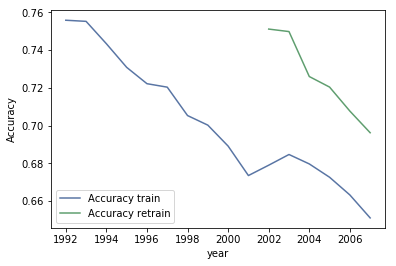

In [69] used 0.0000 MiB RAM in 0.41s, peaked 0.00 MiB above current, total RAM usage 78568.90 MiB


In [69]:
# Airline Retrain Results
ax = plot_metrics(accuracy_dict, accuracy_retrain, legend1='Accuracy train', legend2='Accuracy retrain', x_label='year', 
             y_label='Accuracy')
fig = ax.get_figure()
fig.savefig('airline.svg', bbox_inches='tight')

As it can be seen, the performance is better after retraining. We have found concept drift in this dataset.